# Playground notebook

## Imports and settings

In [5]:
import src

import os
import numpy as np
import sys
import re
import pickle
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #"" for CPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from matplotlib import animation

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8146009886257185602
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.
<br>
The data with hourly resolutions spans from 1995 to 2012.<br><br>
Additionally there is data with 5 minutes resolution available here: 
https://opendata.dwd.de/weather/radar/composit/rx/<br>
The span of this is the last two days and it is updated constantly.

In [ ]:
inputs = src.get_data(sys.path[0]+"/rain_hourly", which="h",total_length=4, mask=True)

In [ ]:
t, v, s = src.load_datasets()

### Wind measurements
Here I'm loading wind measurements. This is important because later we might experiment not only with rain (the density field) but with the wind (velocity field) too. This is because in the [tempoGAN](https://arxiv.org/pdf/1801.09710.pdf) paper they also use the velocity and without it that might be very difficult to build the GAN. I have downloaded two datasets for the wind:<br><br>
_Wind direction:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DD_201208.nc.gz__<br>
_Wind speed:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/FF_201208.nc.gz__<br>
_DWD manuals:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_direction_en.pdf__
<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_speed_en.pdf__<br><br>
I create two datasets out of these. They contain the $x$ and $y$ velocity components.
The measurements are in $\displaystyle0.1\,\frac{m}{s}$.
<br><br>
_<font color='red'>__Issue__:</font> [Mostly](https://www.nationalgeographic.com/science/earth/earths-atmosphere/clouds/) an average rain cloud is at $2000\,m$ high. Normal clouds can be up to $6000\,m$ high. We only have wind measurements recorded at $10\,m$. 
We can use e.g. [this](https://websites.pmc.ucsc.edu/~jnoble/wind/extrap/) to calculate wind speed at higher altitudes. We can't correct the change in wind direction so this remains a weak point in the simulations._

In [2]:
#the paths are probably different for you
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')  # direction DD
w_vel = Dataset(sys.path[0]+'/wind_speed/FF_201008_CF.nc')  # velocity FF
cloud = Dataset(sys.path[0]+'/cloud/N_201008_CF.nc')  # cloud cover CF

In [ ]:
w_vel["datum"][743]

This reads wind direction and magnitude datasets. They are hourly distributed and I use the dataset of 2010. August. The dates of the measurements begin with 2018.08.01.00:00:00. There are 744 = 24$\cdot$31 maps, each 938*720 pixels. This cell below is very memory consuming so this is just a demonstration here to look over the data.

In [ ]:
#creating vx and vy datasets from |v| and phi
vx = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:10]), np.zeros(w_dir['DD'][:10].shape))
vy = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:10]), np.zeros(w_dir['DD'][:10].shape))
for t in range(np.shape(vx)[0]):
    src.update_output(f"[{t+1}/{np.shape(vx)[0]}]")
    vx[t] = np.flip(w_vel["FF"][t]*np.sin(np.deg2rad(w_dir['DD'][t])),axis = 0)
    vy[t] = np.flip(w_vel["FF"][t]*np.cos(np.deg2rad(w_dir['DD'][t])),axis = 0)

This cell below extract the radar grid of these wind measurements. So a $938\cdot720$ long dataframe is created with the latitude and longitude coordinates of the center of each grid point. The individual cells are labeled with a cell ID which is just an integer value similar to the index.

In [ ]:
#gps grid of wind maps
#47.075
wind_grid = pd.DataFrame(data={'LAT':w_vel['lat'][:].flatten(),
                               'LON':w_vel['lon'][:].flatten()}).reset_index().rename(columns={"index":"CELL_ID"})

Here I plot some examples for sanity check that the wind direction is preserved after the velocity x and y calculation.

In [ ]:
#sanity checks
%matplotlib notebook
idx = 0
fig = plt.figure(figsize=(8,8))
# NE, N, NW
plt.subplot(2,2,1)
plt.imshow(np.ma.masked_where(vy[idx] < 0, vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("All northern wind")

plt.subplot(2,2,2)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]>=90)& (w_dir['DD'][idx]<=270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("All northern wind truth")

# SW
plt.subplot(2,2,3)
plt.imshow(np.ma.masked_where((vy[idx]>0)|(vx[idx]>0), vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind")

plt.subplot(2,2,4)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]<180)| (w_dir['DD'][idx]>270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind truth")

plt.subplots_adjust(hspace=0.3, wspace=0.3)

## Visualise channels

This part is valid if one already has the rain data interpolated to the wind grid. If not scroll down for some info on it.

In [163]:
rho = Dataset(sys.path[0]+"/rain_density/rho.nc")

In [ ]:
rho["field"][0].shape

<IPython.core.display.Javascript object>


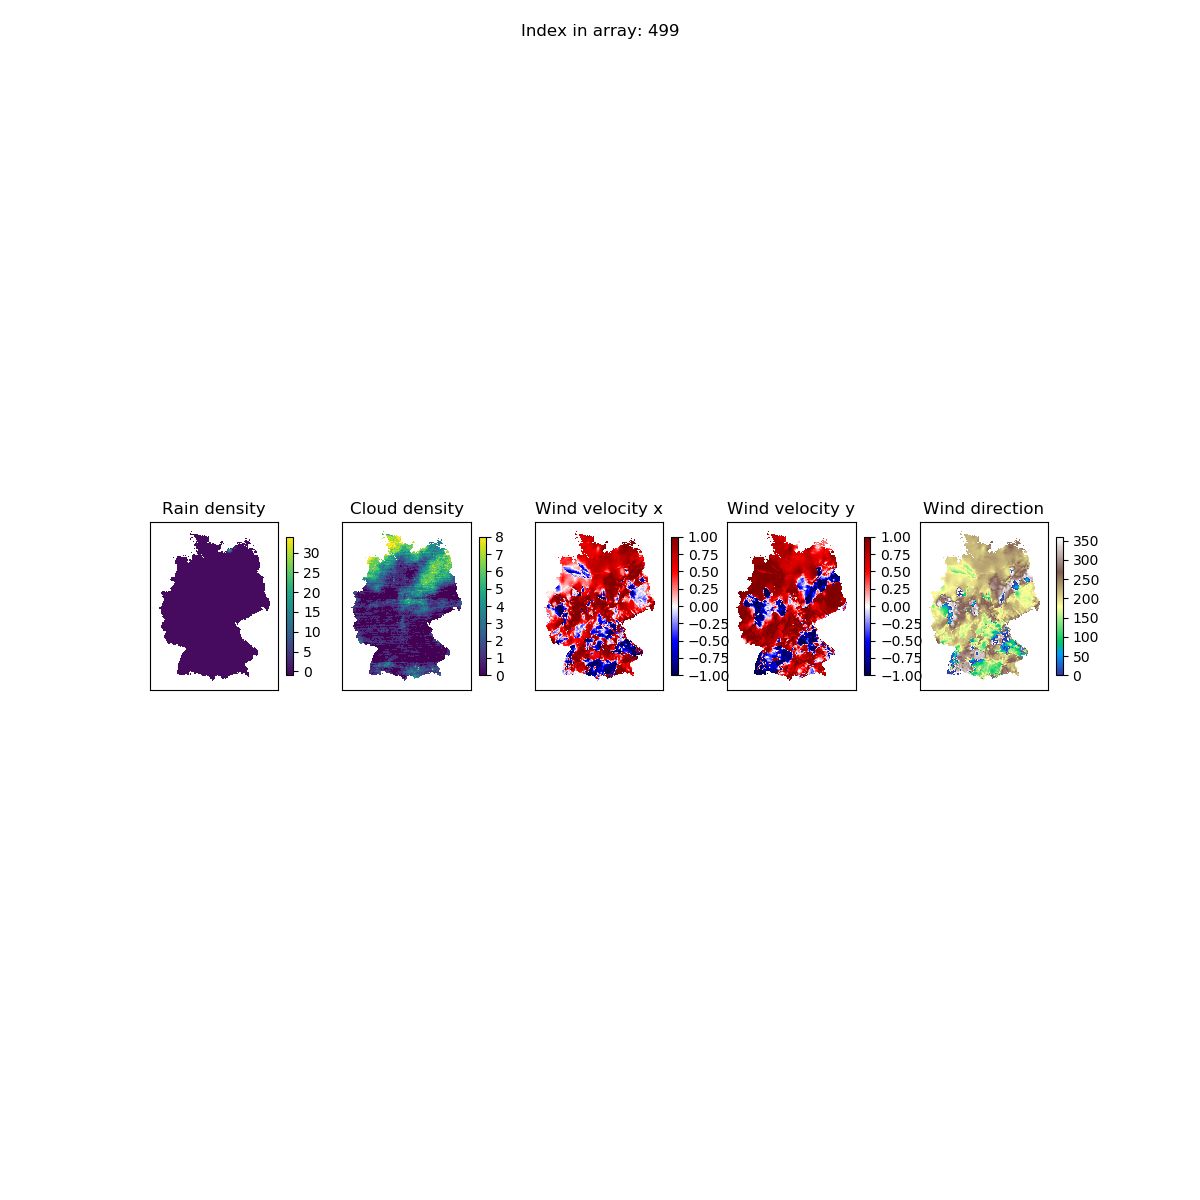

In [7]:
%matplotlib notebook
#visualise channels
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(12,12))
for ax in [ax1,ax2,ax3,ax4, ax5]:
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,      # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
ax1.set_title("Rain density")
ax2.set_title("Cloud density")
ax3.set_title("Wind velocity x")
ax4.set_title("Wind velocity y")
ax5.set_title("Wind direction")
line1 = ax1.imshow(rho["field"][0]) # start from index 0 which means 0:50:00
line2 = ax2.imshow(np.flip(cloud["CF"][1],axis = 0)) # start from index 1 which means 1:00:00
line3 = ax3.imshow(-np.flip(np.sin(np.deg2rad(w_dir['DD'][1])),axis = 0),cmap="seismic")
line4 = ax4.imshow(-np.flip(np.cos(np.deg2rad(w_dir['DD'][1])),axis = 0),cmap="seismic")
line5 = ax5.imshow(np.flip(w_dir["DD"][1],axis = 0),cmap="terrain")
line = [line1, line2, line3, line4, line5]

sh = 0.15
fig.colorbar(line1, ax=ax1,shrink=sh)
fig.colorbar(line2, ax=ax2,shrink=sh)
fig.colorbar(line3, ax=ax3,shrink=sh)
fig.colorbar(line4, ax=ax4,shrink=sh)
fig.colorbar(line5, ax=ax5,shrink=sh)

def run(i):
    line[0].set_data(rho["field"][i])
    line[1].set_data(np.flip(cloud["CF"][i+1],axis = 0))
    line[2].set_data(-np.flip(np.sin(np.deg2rad(w_dir['DD'][i+1])),axis = 0))
    line[3].set_data(-np.flip(np.cos(np.deg2rad(w_dir['DD'][i+1])),axis = 0))
    line[4].set_data(np.flip(w_dir["DD"][i+1],axis = 0))
    fig.suptitle(f"Index in array: {i}")
    return line

ani = animation.FuncAnimation(fig, run, blit=True, interval=400, frames=500,
    repeat=False)
plt.show()

### Create datasets for temporal GAN

In [364]:
test = generate_tempoGAN_datasets(rho["field"], w_vel["FF"], w_dir["DD"], n=10,length=4, normalize=True)

[10/10]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


<IPython.core.display.Javascript object>


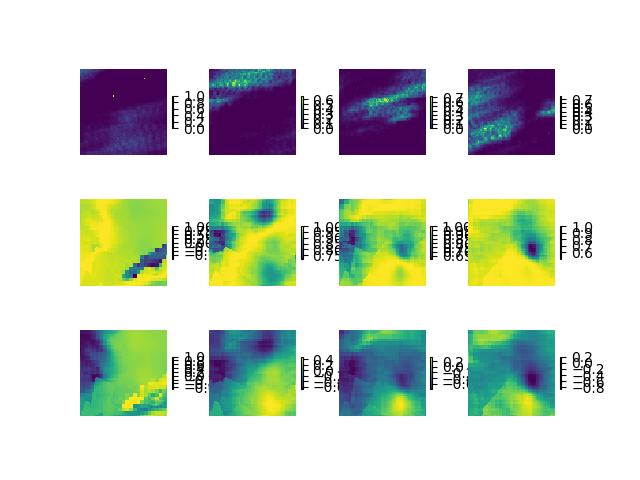

(-0.5, 63.5, 63.5, -0.5)

In [367]:
sample=8
plt.subplot(3,4,1)
plt.imshow(test[sample,0,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,2)
plt.imshow(test[sample,1,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,3)
plt.imshow(test[sample,2,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,4)
plt.imshow(test[sample,3,:,:,0])
plt.colorbar(shrink=0.3)
plt.axis('off')

plt.subplot(3,4,5)
plt.imshow(test[sample,0,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,6)
plt.imshow(test[sample,1,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,7)
plt.imshow(test[sample,2,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,8)
plt.imshow(test[sample,3,:,:,1])
plt.colorbar(shrink=0.3)
plt.axis('off')

plt.subplot(3,4,9)
plt.imshow(test[sample,0,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,10)
plt.imshow(test[sample,1,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,11)
plt.imshow(test[sample,2,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')
plt.subplot(3,4,12)
plt.imshow(test[sample,3,:,:,2])
plt.colorbar(shrink=0.3)
plt.axis('off')

In [263]:
size=64
time = 743
h = rho["field"][0].shape[0] #938
w = rho["field"][0].shape[1] #720
length = 4
image = np.empty((length,size,size,3))
anchor = (np.random.randint(0, time - 2), np.random.randint(0, h - size), np.random.randint(0, w - size))
print(anchor)
for i in range(length):
    r = rho["field"][anchor[0]+i]
    x = -np.flip(np.sin(np.deg2rad(w_dir["DD"][anchor[0]+1+i])),axis = 0)
    y = -np.flip(np.cos(np.deg2rad(w_dir["DD"][anchor[0]+1+i])),axis = 0)
    image[i,:,:,0] = r[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
    image[i,:,:,1] = x[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
    image[i,:,:,2] = y[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)

(641, 135, 573)


In [363]:
def generate_tempoGAN_datasets(rain_density, wind_vel, wind_dir, n=10,length=2, size=64, split=None, normalize=False):
    """
    Splits input array into training, cross validation and test sets.
    :param array: 3D np array, dataset to be split. This is a channel*900*900 large array of rain radar maps.
    Data is created by cutting size*size frames randomly from 2 consecutive maps.
    :param n: int, total number of data instances to make
    :param size: int, height and width in pixels of each frame
    :param split: list or np array of either floats between 0 and 1 or positive integers. Set to None by deafult
    which means no splitting, just return all instances in one set.
    :return: 3D np array, either one dataset of smaller image frames or three datasets for training,
    cross validating and testing
    """
    time = 743
    h = rain_density[0].shape[0] #938
    w = rain_density[0].shape[1] #720


    images = np.zeros((n, length, size, size,3))  # n series, each of size size**2 and rho,vx,vy,future frames as channels
    for i in range(n):
        src.update_output(f"[{i+1}/{n}]")
        # draw 3 random numbers for map number and idx of top left pixel of window
        valid = 0
        while not valid:
            anchor = (np.random.randint(0, time - 2), np.random.randint(0, h - size), np.random.randint(0, w - size))
            image = np.empty((length,size,size,3))
            for j in range(length):
                r = rain_density[anchor[0]+j]
                x = -np.flip(np.sin(np.deg2rad(wind_dir[anchor[0]+1+j])),axis = 0)
                y = -np.flip(np.cos(np.deg2rad(wind_dir[anchor[0]+1+j])),axis = 0)
                image[j,:,:,0] = r[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
                image[j,:,:,1] = x[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
                image[j,:,:,2] = y[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
            # first channel is the current frame, the next two are the wind x and y components where the index is shifted by 1
            # because the rain dates are in xx:50 resolution but the wind is in xx:00. The next channels are the next rain fields
            # to be predicted
            valid = valid_image(image)
        images[i] += image
    
    if normalize: #to [0,1] only for rain
        images[:,:,:,:,0] = np.array([s[:,:,:,0]/s[:,:,:,0].max() for s in images])
    txt = f"Shape of data: {np.shape(images)}"
    if split is not None:  # split
        if all((r <= 1) & (r >= 0) for r in split):
            assert (sum(split) == 1), "Split values must sum up to 1."
            train = images[:int(n * split[0])]
            xval = images[int(n * split[0]):int(n * (split[0] + split[1]))]
            test = images[int(n * (split[0] + split[1])):]
        elif all(isinstance(r, int) for r in split):
            train = images[:int(n * split[0] / sum(split))]
            xval = images[int(n * split[0] / sum(split)):int(n * (split[0] + split[1]) / sum(split))]
            test = images[int(n * (split[0] + split[1]) / sum(split)):]
        else:
            sys.exit("All split values must be either fractions for percentages or integers.")

        txt = txt + f"\n\nTraining set: {np.shape(train)}\nValidation set: {np.shape(xval)}\nTest set: {np.shape(test)}"
        src.update_output(txt)
        return {"train":train,
                "xval": xval,
                "test": test,}
    else:  # no split
     #   src.update_output(txt)
        return images

In [340]:
def valid_image(image):
    """
    Filters out some useless data. in the junk variable several conditions are defined to check on the images.
    Currently it checks the number of different entry values and if 0s or 1s make up 0.75 part of the whole data.
    This throws out the cuts made inside or almost inside the mask region and rainless areas.
    Still can be improved.
    :param image: 3D np array, dimensions are the number of consecutive frames, height and width
    :return: bool, whether the data instance is valid in terms of usability
    """
    if len(np.shape(image)) == 3: #one channel frames
        junk = [len(set(np.array(frame).flatten()[
                     ~np.isnan(np.array(frame).flatten())])) <= 8 for frame in image]
    elif len(np.shape(image)) == 4: #three channel frames
        #frame is a triplet for tempogan images
        #only rain channel
        junk = [len(set(np.array(frame[:,:,0]).flatten()[
                     ~np.isnan(np.array(frame[:,:,0]).flatten())])) <= 8 for frame in image]
        
    junk += [len(np.array(frame).flatten()[
                     np.isnan(np.array(frame).flatten())]) > 0.25 * len(np.array(frame).flatten()) for frame in image]
    return 0 if any(junk) else 1

# Machting rain cells to wind cells
Don't run this if the rain density data on the wind grid is available.

### Radar coordinates
The gps coordinates of the radar grid for the rain measurements.

In [ ]:
coords = src.get_rain_grid_coords()

In [ ]:
reduced_coords = coords[coords["LON"]>= germany["LON"].min()]
reduced_coords

### Germany
GPS coordinates of Germany. This is a subset of the wind grid. As next I'm matching wind grid cells with the nearest rain cells. As seen on the plot below, the rain and wind data comes from a different radar measurement method so they have a different grid map so the grid points are not identical.

In [ ]:
try:
    with open('germany.pickle', 'rb') as handle:
        germany = pickle.load(handle)
except:
    #this takes 1 night
    src.get_germany(w_vel, coords)
germany

In [ ]:
%matplotlib notebook

#plot wind grid
plt.scatter(wind_grid["LON"], wind_grid["LAT"],s=0.2, label="wind grid")
#plot rain grid
plt.scatter(coords["LON"], coords["LAT"],s=0.2, label="rain grid")
#plot wind grid points inside Germany
plt.scatter(germany["LON"],germany["LAT"],s=10, label="Germany on wind grid")
#plot rain grid points that are the nearest neighbors to each wind grid cell inside Germany
#plt.scatter(coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LON"],
#            coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LAT"],
#            s=10, label="rain grid")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Rain and wind radar grids")
lgnd = plt.legend(loc="lower right")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
plt.savefig("grids.png")

Create density channel (rain) with the grid of the wind maps. We need 3 channels: [rain,vx,vy]<br>
Since the wind data is available until the end of 2012, we can only create three channels using the hourly resolution. 5 min data is available only for the past 48 hours.

In [ ]:
rho = np.ma.masked_where(np.flip(np.ma.getmask(w_dir['DD'][:144]),axis=1),
                         np.zeros((144,w_dir['DD'].shape[1],w_dir['DD'].shape[2])))
rho[:,938-germany["CELL_ID"]//720,
    germany["CELL_ID"]%720] = inputs[600:,900-germany["CLOSEST_RAIN_CELL_ID"]//900, germany["CLOSEST_RAIN_CELL_ID"]%900]
rho.shape

In [ ]:
%matplotlib notebook
idx = 45
plt.subplot(1,3,1)
plt.imshow(np.ma.masked_where(inputs[200+idx] < 0,inputs[200+idx]))
plt.title("RADOLAN rain")
plt.subplot(1,3,2)
plt.imshow(rho[idx])
plt.title("Interpolated rain")
plt.subplot(1,3,3)
plt.imshow(vy[idx])
plt.title("Wind")
plt.show()

In [ ]:
new = np.ma.concatenate((a["field"][:], rho), axis=0)

Creating .nc file.

In [ ]:
#root_grp.close()
root_grp = Dataset('rho.nc', 'w', format='NETCDF4')
root_grp.description = 'Example simulation data'

lat_n = 938
lon_n = 720
xdimension = 0.75
ydimension = 0.75
# dimensions
root_grp.createDimension('time', None)
root_grp.createDimension('lat', lat_n)
root_grp.createDimension('lon', lon_n)

# variables
time = root_grp.createVariable('time', 'c', ('time',))
x = root_grp.createVariable('lat', 'c', ('lat',))
y = root_grp.createVariable('lon', 'c', ('lon',))
field = root_grp.createVariable('field', 'f4', ('time', 'lat', 'lon',))

field[:,:,:] = new

root_grp.close()

In [ ]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)